In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import spams
from PIL import Image
from src.utils_dgmca import divisorGenerator
from src.utils_dgmca import Make_Experiment_GG
from src.utils_dgmca import mad
from src.utils_dgmca import generate_2D_generalized_gaussian
from src.misc_dgmca import *
from src.DGMCA import DGMCA as dgmca
from src.DGMCA_euclidean import DGMCA_euclidean
from src.GMCA import GMCA as gmca
import copy as cp
from tqdm import tqdm
import time

In [2]:
data_path = 'data/'
plots_path = 'plots/'


# Define your own list of batch sizes
divisors = np.array([ 50, 100, 200,  500, 1000])

lambdas = np.linspace(0.01,0.3,15)

n_lambda = len(lambdas)
n_s = 10 # Number of sources
n_obs = 20 # Number of observations
rho = 0.5 # Generalized Gaussian generation parameter
alpha_init = 2. # Alpha parameter for the thresholding strategy

rho = np.array([0.35,0.5,0.7,1.0,1.4])
totalSize = 1000

numIts = 3 # Number of repetitions of the experiment

CA_ODL = np.zeros([2,len(divisors),n_lambda,numIts])
time_ODL = np.zeros([len(divisors),n_lambda,numIts])

# Recapitulative of the chosen parameters
print('*******************************************')
print('totalSize: ' + str(totalSize))
print('divisors: ' + str(divisors))
print('numIts: ' + str(numIts))
print('rho: ' + str(rho))
print('alpha_init: ' + str(alpha_init))
print('n_s: ' + str(n_s))
print('n_obs: ' + str(n_obs))
print('*******************************************')

*******************************************
totalSize: 1000
divisors: [  50  100  200  500 1000]
numIts: 3
rho: [0.35 0.5  0.7  1.   1.4 ]
alpha_init: 2.0
n_s: 10
n_obs: 20
*******************************************


In [20]:
def Make_Experiment_GG2(A = None, n_s=2,n_obs=2,t_samp=1024,noise_level=40,dynamic=0,CondNumber=1,alpha=2):

    S = generate_2D_generalized_gaussian(n_s, t_samp, alpha=alpha)

    val = np.power(10,(-np.linspace(1,n_s-1,n_s)/(n_s-1)*dynamic))

    if A is None:
        A0 = np.random.randn(n_obs,n_s)

        if CondNumber == 1:
            Uq,Sq,Vq = np.linalg.svd(A0)
            A0 = Uq[:,0:n_s]

        if CondNumber > 1:
            for r in range(10):
                Uq,Sq,Vq = np.linalg.svd(A0)
                Sq = 1./np.linspace(1,CondNumber,n_s)
                A0 = np.dot(Uq[:,0:n_s],np.dot(np.diag(Sq),Vq.T))
                A0 = np.dot(A0,np.diag(1./np.sqrt(np.sum(A0*A0,axis=0))))
    else:
        A0 = A

    S0= np.dot(np.diag(1./np.sqrt(np.sum(S*S,axis=1))),S)
    S0 = np.dot(np.diag(val),S0)
    X0 = np.dot(A0,S0)

    N = np.random.randn(n_obs,t_samp)
    sigma_noise = np.power(10.,(-noise_level/20.))*np.linalg.norm(X0,ord='fro')/np.linalg.norm(N,ord='fro')
    N = sigma_noise*N

    X = X0 + N

    return X,X0,A0,S0,N

def makeMyExperiment(n_s=10,n_obs=20,t_samp=5000,noise_level=15.0,\
                                      dynamic=0,CondNumber=10,alpha=0.5):
    
    n_alpha = len(alpha)
    
    if n_alpha == 1:
        X,X0,A0,S0,N = Make_Experiment_GG2(A = None,n_s=n_s,n_obs=n_obs,t_samp=totalSize,noise_level=noise_level,\
                                dynamic=0,CondNumber=CondNumber,alpha=alpha)
    else:
        X,X0,A0,S0,N = Make_Experiment_GG2(A = None,n_s=n_s,n_obs=n_obs,t_samp=totalSize,\
                                    noise_level=noise_level,dynamic=0,CondNumber=CondNumber,alpha=alpha[0])
    
    for it in range(n_alpha-1):
    
        X_2,X0_2,A0_2,S0_2,N_2 = Make_Experiment_GG2(A = A0,n_s=n_s,n_obs=n_obs,t_samp=totalSize,\
                                    noise_level=noise_level,dynamic=0,CondNumber=CondNumber,alpha=alpha[it+1])
    
        X = np.concatenate((X,X_2),axis=1)
        X0 = np.concatenate((X0,X0_2),axis=1)
        S0 = np.concatenate((S0,S0_2),axis=1)
        N = np.concatenate((N,N_2),axis=1)
        
    return X,X0,A0,S0,N
        

In [21]:
for it_n in range(numIts):
  
    X,X0,A0,S0,N = makeMyExperiment(n_s=n_s,n_obs=n_obs,t_samp=totalSize,noise_level=15.0,\
                                  dynamic=0,CondNumber=10,alpha=rho)
    
    X_ODL = np.asfortranarray(cp.deepcopy(X))


    for it1 in tqdm(range(len(divisors))):
        numBlock = totalSize/divisors[it1]
        sizeBlock = divisors[it1]
        
        for it2 in range(len(lambdas)):
            lda = lambdas[it2]
            
            # ODL (Online Dictionary Learning)
            param = { 'K' : n_s, 'lambda1' : lda, 'numThreads' : 4, 'batchsize' : sizeBlock,
            'iter' : 1000, 'mode' : 0, 'modeD' : 0}
            time1 = time.time()
            A_ODL = spams.trainDL(X_ODL,**param)
            time_ODL[it1,it2,it_n] = time.time() - time1
            crit_ODL = EvalCriterion_eval(A0,S0,A_ODL,S0) 
            CA_ODL[0,it1,it2,it_n] = crit_ODL['ca_mean']
            CA_ODL[1,it1,it2,it_n] = crit_ODL['ca_med']     


100%|██████████| 5/5 [06:40<00:00, 97.24s/it]


In [22]:
# Results
CA_ODL_mean = np.mean(CA_ODL,axis=3)
CA_ODL_med = np.median(CA_ODL,axis=3)

dB_CA_ODL_mean = -10*np.log10(CA_ODL_mean)
dB_CA_ODL_med = -10*np.log10(CA_ODL_med)


# Save variables
title_CA_ODL = data_path + 'CA_ODL' + title_str  
np.save(title_CA_ODL,CA_ODL)

# Import
ext = '.npy'
imp_CA_ODL = np.load(title_CA_ODL + ext)

# Mean over the experiments
imp_CA_ODL = np.mean(imp_CA_ODL,axis=3) # Over the iterations

# To dB
log_imp_CA_ODL = -10*np.log10(imp_CA_ODL)


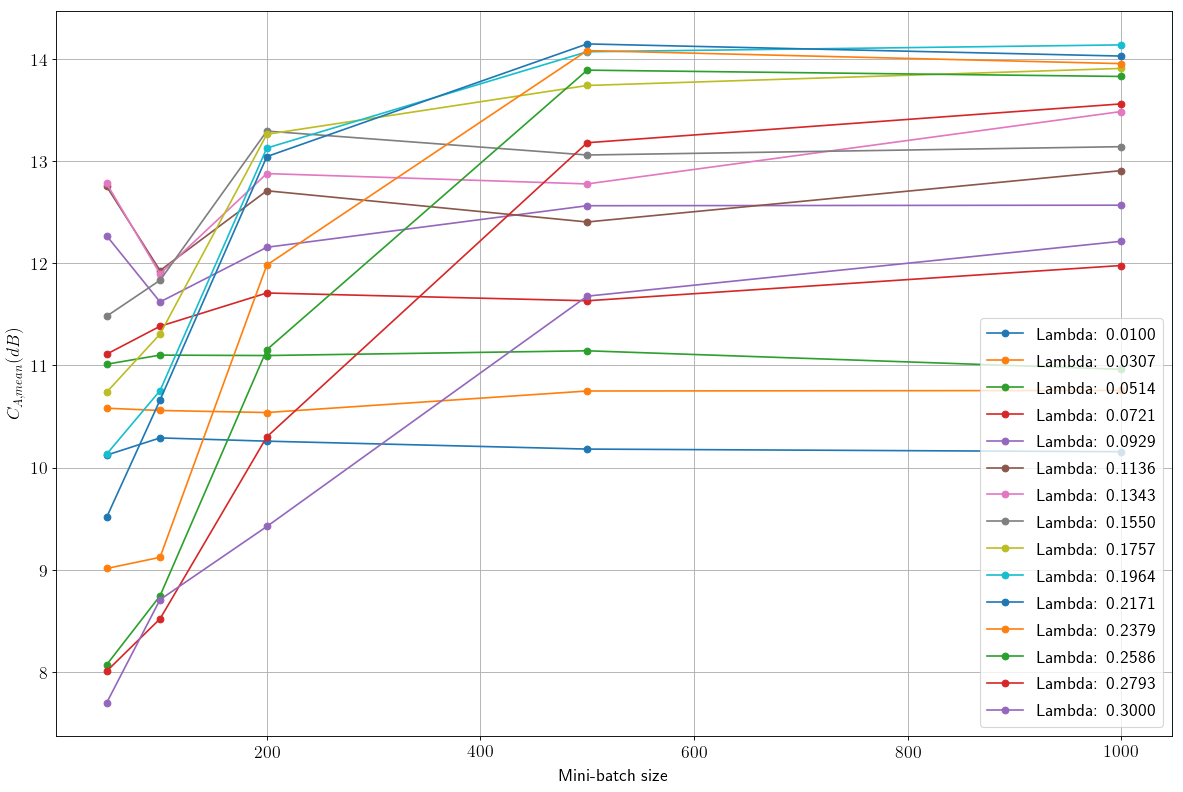

In [23]:
# Use the mean or the median over the CA 
type_ca = 0# 0 = CA_mean // 1 = CA_median

matplotlib.rcParams.update({'font.size': 16}) # 23
fig=plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.rc('text', usetex=True)

for it in range(len(lambdas)):
    plt.plot(divisors[:], log_imp_CA_ODL[type_ca,:,it], '-o', label=r'Lambda: %.4f'%(lambdas[it]))

plt.xlabel('Mini-batch size')
if type_ca == 0:
    plt.ylabel(r'$C_{A,mean}(dB)$')
elif type_ca == 1:
    plt.ylabel(r'$C_{A,med}(dB)$')
plt.grid()
plt.legend()
plt.show()

title_str_pdf = plots_path + 'test_optim_ODL' + ".pdf"
fig.savefig(title_str_pdf, bbox_inches='tight')